In [32]:
!pip install albumentations utils

In [33]:
import os
import glob
import random
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import matplotlib.patches as patches
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import albumentations as A
from albumentations import Compose, RandomResizedCrop, HorizontalFlip, RandomBrightnessContrast, ColorJitter, Normalize
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
import utils
from torchvision.ops import box_iou

In [34]:
# Define collate function
def collate_fn(batch):
    return tuple(zip(*batch))

In [35]:
# Define the training function
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % print_freq == 0:
            print(f"Epoch [{epoch}], Step [{i}], Loss: {losses.item():.4f}")


In [36]:
# Define the evaluation function
@torch.no_grad()
def evaluate(model, data_loader, device):
    model.eval()
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        outputs = model(images, targets)
        # Add evaluation metrics if needed
        print(outputs)

In [37]:
# Load dataset and visualize distribution
dataset_root = '/kaggle/input/martianlunar-crater-detection-dataset/craters'
for subset_folder in ['train', 'valid', 'test']:
    subset_images = glob.glob(os.path.join(dataset_root, subset_folder, 'images','*.jpg'))
    print(f"Number of {subset_folder} images:", len(subset_images))

Number of train images: 98
Number of valid images: 26
Number of test images: 19


In [38]:
# Define augmentation transforms with bbox_params
aug_transform = A.Compose([
    A.RandomResizedCrop(640, 640, scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ColorJitter(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))


In [39]:
class CraterDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(self.root, "images"))))
        self.annots = list(sorted(os.listdir(os.path.join(self.root, "labels"))))
        self.classes = ['Background', 'Crater']
        
    # Converts boundary box formats, this version assumes single class only!
    def convert_box_cord(self, bboxs, format_from, format_to, img_shape):
        if format_from == 'normxywh':
            if format_to == 'xyminmax':
                xw = bboxs[:, (1, 3)] * img_shape[1]
                yh = bboxs[:, (2, 4)] * img_shape[0]
                xmin = xw[:, 0] - xw[:, 1] / 2
                xmax = xw[:, 0] + xw[:, 1] / 2
                ymin = yh[:, 0] - yh[:, 1] / 2
                ymax = yh[:, 0] + yh[:, 1] / 2
                coords_converted = np.column_stack((xmin, ymin, xmax, ymax))
        
        return coords_converted
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annot_path = os.path.join(self.root, "labels", self.annots[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img = img / 255.0

        if os.path.getsize(annot_path) != 0:
            bboxs = np.loadtxt(annot_path, ndmin=2)
            bboxs = self.convert_box_cord(bboxs, 'normxywh', 'xyminmax', img.shape)
            num_objs = len(bboxs)
            bboxs = torch.as_tensor(bboxs, dtype=torch.float32)
            labels = torch.ones((num_objs,), dtype=torch.int64)
            iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        else:
            bboxs = torch.as_tensor([[0, 0, 640, 640]], dtype=torch.float32)
            labels = torch.zeros((1,), dtype=torch.int64)
            iscrowd = torch.zeros((1,), dtype=torch.int64)

        area = (bboxs[:, 3] - bboxs[:, 1]) * (bboxs[:, 2] - bboxs[:, 0])
        image_id = torch.tensor([idx])

        target = {
            "boxes": bboxs,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        if self.transforms is not None:
            transformed = self.transforms(image=img, bboxes=target['boxes'], labels=target['labels'])
            img = transformed['image']
            target['boxes'] = torch.tensor(transformed['bboxes'])
            target['labels'] = torch.tensor(transformed['labels'])

        if target['boxes'].ndim == 1:
            target['boxes'] = torch.as_tensor([[0, 0, 640, 640]], dtype=torch.float32)
            target['labels'] = torch.zeros((1,), dtype=torch.int64)

        return img, target

    def __len__(self):
        return len(self.imgs)

    def get_subset(self, indices):
        # Return subset of dataset based on indices
        return Subset(self, indices)

    def get_labels(self, indices):
        # Return labels for subset of dataset based on indices
        return torch.tensor([self[idx][1]['labels'] for idx in indices])

    def get_image(self, idx):
        # Return image for a specific index
        return self[idx][0]

In [40]:
# Paths to dataset
train_data_path = os.path.join(dataset_root, 'train')
valid_data_path = os.path.join(dataset_root, 'valid')
test_data_path = os.path.join(dataset_root, 'test')

# Create datasets and data loaders
train_dataset = CraterDataset(root=train_data_path, transforms=aug_transform)
valid_dataset = CraterDataset(root=valid_data_path, transforms=T.ToTensor())
test_dataset = CraterDataset(root=test_data_path, transforms=T.ToTensor())

# Convert datasets to DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)



In [41]:
# Function to count images in each subset and visualize distribution
def count_images(dataset_root):
    subsets = ['train', 'valid', 'test']
    subset_counts = {}
    for subset in subsets:
        image_paths = glob.glob(os.path.join(dataset_root, subset, 'images', '*.jpg'))
        subset_counts[subset] = len(image_paths)
    return subset_counts

In [42]:
# Count images in each subset
subset_counts = count_images(dataset_root)
print("Number of images in each subset:")
print(subset_counts)

Number of images in each subset:
{'train': 98, 'valid': 26, 'test': 19}


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


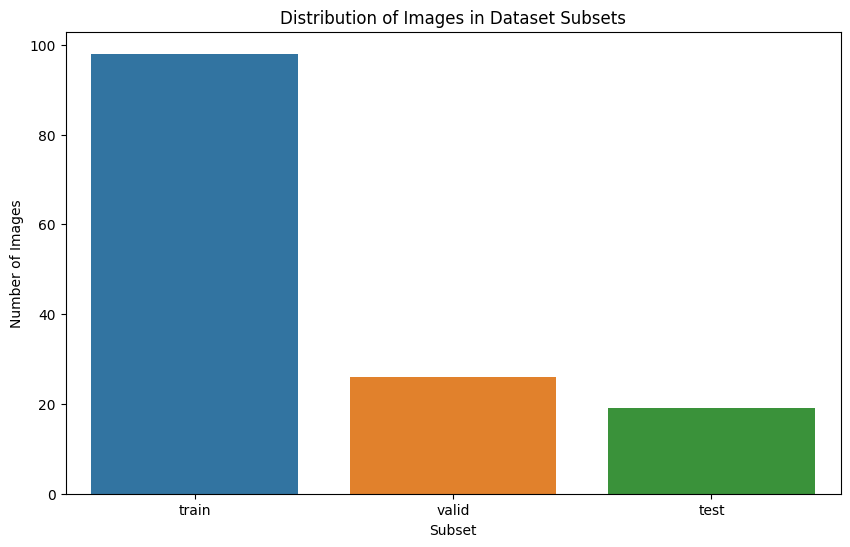

In [43]:
# Visualize distribution of images in each subset
plt.figure(figsize=(10, 6))
sns.barplot(x=list(subset_counts.keys()), y=list(subset_counts.values()))
plt.title('Distribution of Images in Dataset Subsets')
plt.xlabel('Subset')
plt.ylabel('Number of Images')
plt.show()

In [44]:
# Function to display sample images from each subset
def display_sample_images(dataset_root, num_images_per_subset=3):
    subsets = ['train', 'valid', 'test']
    plt.figure(figsize=(15, 10))
    for i, subset in enumerate(subsets):
        image_paths = glob.glob(os.path.join(dataset_root, subset, 'images', '*.jpg'))
        sample_images = random.sample(image_paths, num_images_per_subset)
        for j, img_path in enumerate(sample_images):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(len(subsets), num_images_per_subset, i * num_images_per_subset + j + 1)
            plt.imshow(img)
            plt.title(f'Subset: {subset}')
            plt.axis('off')
    plt.tight_layout()
    plt.show()

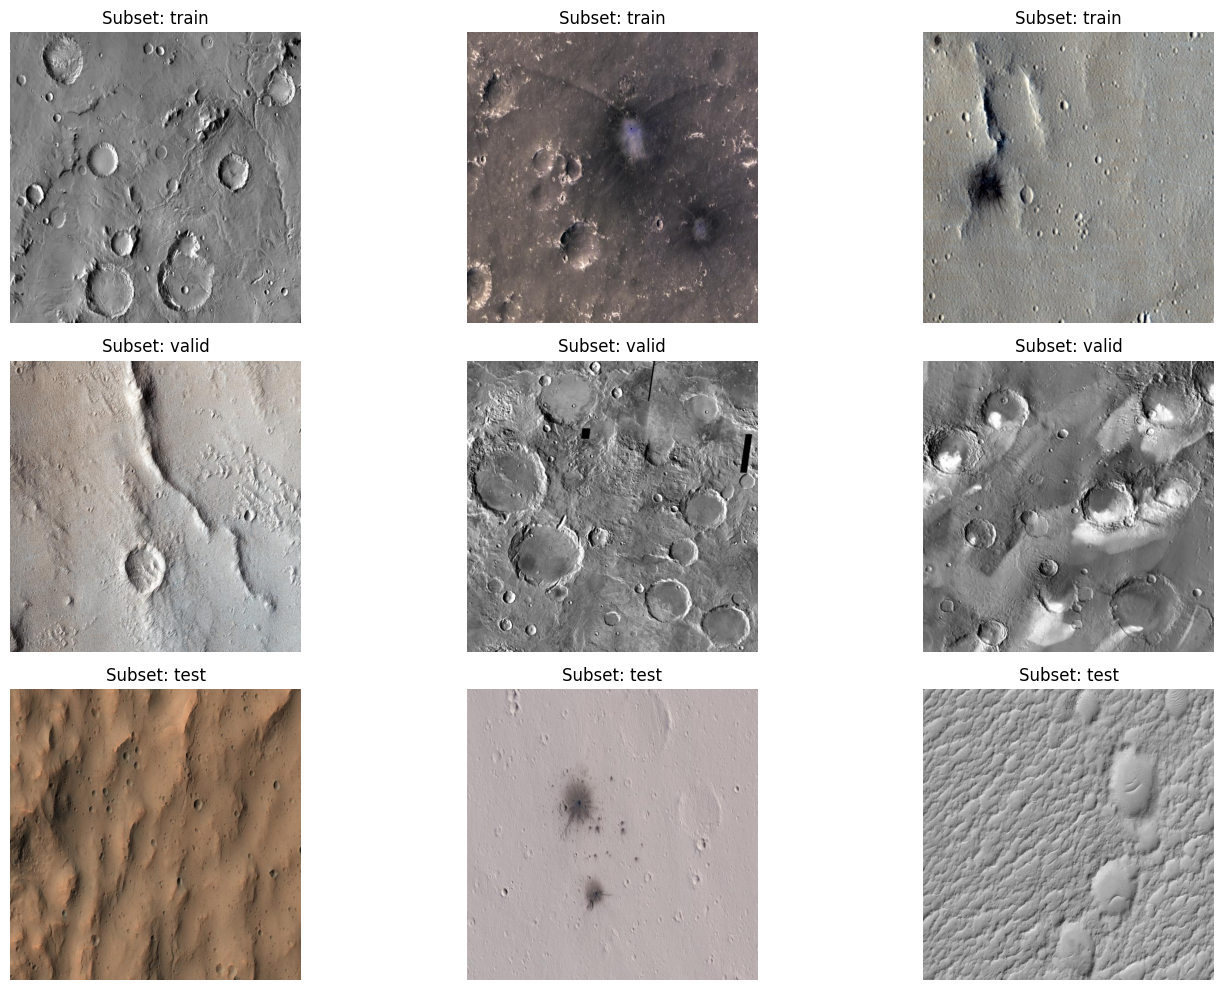

In [45]:
# Display sample images from each subset
display_sample_images(dataset_root, num_images_per_subset=3)

In [46]:
# Function to analyze class distribution (if annotations are available)
def analyze_class_distribution(dataset_root):
    subsets = ['train', 'valid', 'test']
    class_counts = {'crater': 0, 'no_crater': 0}
    for subset in subsets:
        label_paths = glob.glob(os.path.join(dataset_root, subset, 'labels', '*.txt'))
        for label_path in label_paths:
            with open(label_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    class_id = int(line.split()[0])
                    if class_id == 0:
                        class_counts['crater'] += 1
                    else:
                        class_counts['no_crater'] += 1
    return class_counts

In [47]:
# Analyze class distribution
class_counts = analyze_class_distribution(dataset_root)
print("Class distribution:")
print(class_counts)

Class distribution:
{'crater': 1034, 'no_crater': 0}


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


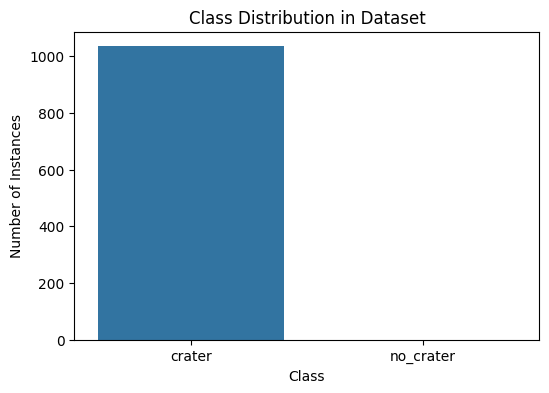

In [48]:
# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Class Distribution in Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.show()

In [49]:
def get_transform(train):
    if train:
        return A.Compose([
            A.HorizontalFlip(0.5),
            A.RandomBrightnessContrast(0.2, 0.2),
            A.ToFloat(max_value=255.0),
            ToTensorV2(),
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    else:
        return A.Compose([
            A.ToFloat(max_value=255.0),
            ToTensorV2(),
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))


In [50]:
def get_model_bbox(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [51]:
# Initialize the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2  # Background and crater
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [52]:
def get_transform(train):
    if train:
        return A.Compose([
            A.HorizontalFlip(0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.RandomCrop(height=512, width=512, p=0.2),
            A.Resize(height=640, width=640),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    else:
        return A.Compose([
            A.Resize(height=640, width=640),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))


In [53]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
        print(f'Reset trainable parameters of layer = {layer}')
        layer.reset_parameters()

In [54]:
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)
    a.imshow(img.permute((1,2,0)))
    for box in (target['boxes']):
        x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 edgecolor='b',
                                 facecolor='none',
                                 clip_on=False)
        a.annotate('Crater', (x,y-20), color='blue', weight='bold',
                   fontsize=10, ha='left', va='top')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

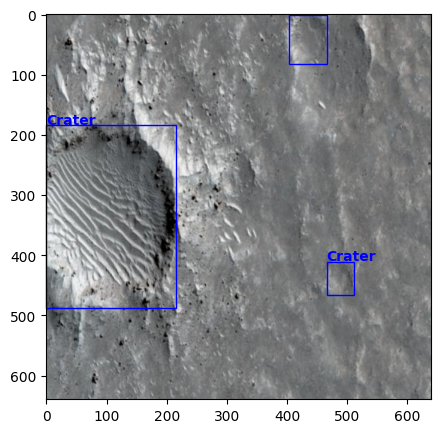

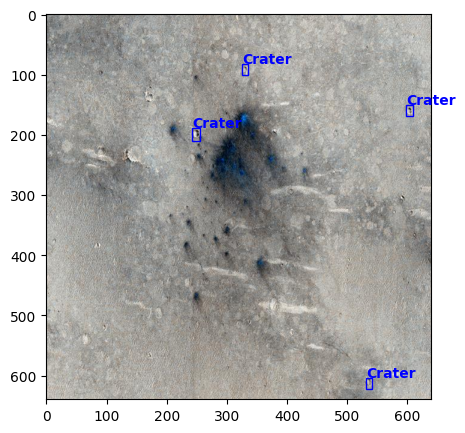

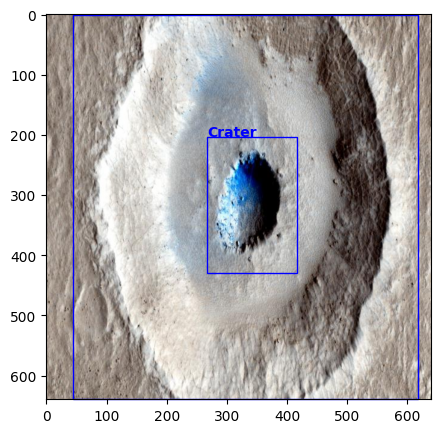

In [55]:
dataset = CraterDataset('/kaggle/input/martianlunar-crater-detection-dataset/craters/train', get_transform(train=True))
# Prints an example of image with annotations
for i in random.sample(range(1, 100), 3):
    img, target = dataset[i]
    plot_img_bbox(img, target)

In [56]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if print_freq > 0 and epoch % print_freq == 0:
            print(f"Epoch {epoch}, Loss: {losses.item()}")


In [57]:
def evaluate(model, data_loader, device):
    model.eval()
    mean_iou = 0
    precision = 0
    recall = 0
    num_images = 0
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            outputs = model(images)

            for output, target in zip(outputs, targets):
                pred_boxes = output['boxes'].to('cpu')
                true_boxes = target['boxes'].to('cpu')

                if len(pred_boxes) == 0 or len(true_boxes) == 0:
                    continue

                ious = box_iou(pred_boxes, true_boxes)
                mean_iou += ious.max(dim=1)[0].mean().item()
                precision += (ious.max(dim=0)[0] > 0.5).float().mean().item()
                recall += (ious.max(dim=1)[0] > 0.5).float().mean().item()
                num_images += 1

    mean_iou /= num_images
    precision /= num_images
    recall /= num_images

    return {'mean_iou': mean_iou, 'precision': precision, 'recall': recall}


In [58]:
num_folds = 3
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 2
num_epochs = 10
print_freq = 1

all_fold_metrics = []

for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
    print(f"Training fold {fold+1}/{num_folds}...")
    train_dataset = dataset.get_subset(train_indices)
    val_dataset = dataset.get_subset(val_indices)

    data_loader_train = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
    data_loader_val = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    for epoch in range(num_epochs):
        train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq)
        lr_scheduler.step()

    metrics = evaluate(model, data_loader_val, device=device)
    if metrics is None:
        raise ValueError(f'Evaluation returned None for fold {fold}. Please check the evaluate function.')

    all_fold_metrics.append(metrics)

mean_metrics = {key: np.mean([fold[key] for fold in all_fold_metrics]) for key in all_fold_metrics[0]}
std_metrics = {key: np.std([fold[key] for fold in all_fold_metrics]) for key in all_fold_metrics[0]}

print(f'Mean metrics over {num_folds} folds: {mean_metrics}')
print(f'Standard deviation of metrics over {num_folds} folds: {std_metrics}')


Training fold 1/3...
Epoch 0, Loss: 1.3512249439310031
Epoch 0, Loss: 0.4495762661585199
Epoch 0, Loss: 0.8051594552935131
Epoch 0, Loss: 1.049818231955809
Epoch 0, Loss: 0.7986568266699705
Epoch 0, Loss: 0.5622367247186977
Epoch 0, Loss: 0.5306797003698901
Epoch 0, Loss: 1.4387632838797275
Epoch 0, Loss: 0.7437025521219416
Epoch 0, Loss: 0.8751291976005257
Epoch 0, Loss: 0.6140638194330796
Epoch 0, Loss: 0.49409665782706835
Epoch 0, Loss: 1.197069802885452
Epoch 0, Loss: 0.6027742645404784
Epoch 0, Loss: 0.5336191843364356
Epoch 0, Loss: 0.535450950284066
Epoch 0, Loss: 1.0004000497519252
Epoch 1, Loss: 0.727879918916324
Epoch 1, Loss: 1.074151279221997
Epoch 1, Loss: 0.3919024426610425
Epoch 1, Loss: 0.3748583534327312
Epoch 1, Loss: 0.9210136461376233
Epoch 1, Loss: 0.40955167481853494
Epoch 1, Loss: 0.47081137332522066
Epoch 1, Loss: 0.860480780867325
Epoch 1, Loss: 0.2511274301190756
Epoch 1, Loss: 0.2611143418051213
Epoch 1, Loss: 0.5554648160574744
Epoch 1, Loss: 0.5896339369030

In [59]:
# Example: Fine-tuning on the entire dataset
dataset_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=collate_fn)
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, dataset_loader, device, epoch, print_freq=50)
    lr_scheduler.step()

# Evaluate on a separate test dataset if available
test_dataset = CraterDataset('/kaggle/input/martianlunar-crater-detection-dataset/craters/test', get_transform(train=False))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)
final_metrics = evaluate(model, test_loader, device=device)
print(f'Final metrics on test dataset: {final_metrics}')

Epoch 0, Loss: 0.2494375430556804
Epoch 0, Loss: 0.3131225684261698
Epoch 0, Loss: 0.34805886465116975
Epoch 0, Loss: 0.23677218324626603
Epoch 0, Loss: 0.23652925090174276
Epoch 0, Loss: 0.5658711611429476
Epoch 0, Loss: 0.546093750549754
Epoch 0, Loss: 0.4618149417369919
Epoch 0, Loss: 0.43761945299678945
Epoch 0, Loss: 0.43497859030743674
Epoch 0, Loss: 0.43526822583088487
Epoch 0, Loss: 0.2732036479427517
Epoch 0, Loss: 0.2210411606053996
Final metrics on test dataset: {'mean_iou': 0.21618794483962545, 'precision': 0.8452253655383462, 'recall': 0.21877390401143776}


In [60]:
# Example: Fine-tuning on the entire dataset
dataset_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=collate_fn)
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, dataset_loader, device, epoch, print_freq=50)
    lr_scheduler.step()

# Evaluate on a separate test dataset if available
test_dataset = CraterDataset('/kaggle/input/martianlunar-crater-detection-dataset/craters/test', get_transform(train=False))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)
final_metrics = evaluate(model, test_loader, device=device)
print(f'Final metrics on test dataset: {final_metrics}')

Epoch 0, Loss: 0.40791709984448105
Epoch 0, Loss: 0.38382239690097425
Epoch 0, Loss: 0.403711660770401
Epoch 0, Loss: 0.38802970179509216
Epoch 0, Loss: 0.36034266137723736
Epoch 0, Loss: 0.22243537095756152
Epoch 0, Loss: 0.3062199893106173
Epoch 0, Loss: 0.4540090735877095
Epoch 0, Loss: 0.3973233675375614
Epoch 0, Loss: 0.5227896797261116
Epoch 0, Loss: 0.535259187041271
Epoch 0, Loss: 0.3396541008083095
Epoch 0, Loss: 1.241617284993345
Final metrics on test dataset: {'mean_iou': 0.2161879576151687, 'precision': 0.8452253655383462, 'recall': 0.21877390401143776}


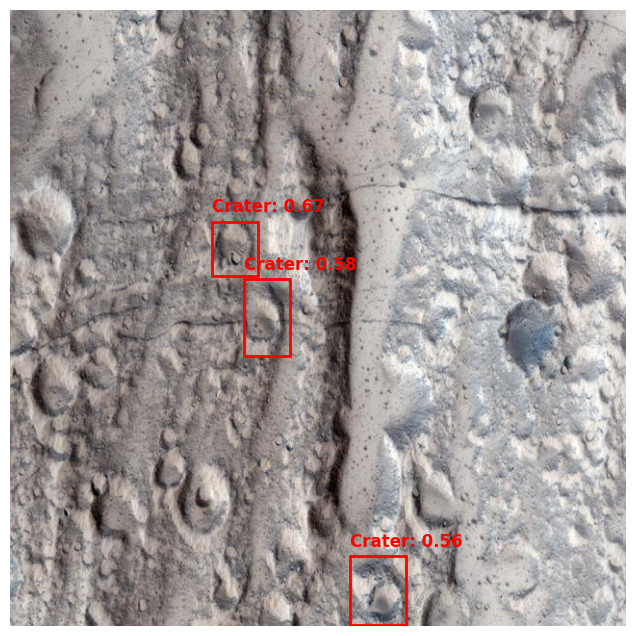

In [63]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms import functional as F

def predict_craters(image_path, model, device, threshold=0.5):
    """
    Predict craters in a single image using a trained Faster R-CNN model.

    Args:
        image_path (str): Path to the input image.
        model (torch.nn.Module): Trained Faster R-CNN model.
        device (torch.device): Device to run the model on (CPU or GPU).
        threshold (float): Confidence threshold for filtering predictions.

    Returns:
        dict: Predicted bounding boxes, labels, and scores.
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Preprocess the image
    transform = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    transformed = transform(image=image)
    input_image = transformed['image'].unsqueeze(0).to(device)

    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        predictions = model(input_image)

    # Extract predictions
    pred_boxes = predictions[0]['boxes'].cpu().numpy()
    pred_scores = predictions[0]['scores'].cpu().numpy()
    pred_labels = predictions[0]['labels'].cpu().numpy()

    # Filter predictions by threshold
    filtered_boxes = pred_boxes[pred_scores >= threshold]
    filtered_scores = pred_scores[pred_scores >= threshold]
    filtered_labels = pred_labels[pred_scores >= threshold]

    return {
        "boxes": filtered_boxes,
        "scores": filtered_scores,
        "labels": filtered_labels
    }


def visualize_predictions(image_path, predictions):
    """
    Visualize predicted bounding boxes on the image.

    Args:
        image_path (str): Path to the input image.
        predictions (dict): Dictionary containing boxes, scores, and labels.
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    # Draw bounding boxes
    for box, score in zip(predictions['boxes'], predictions['scores']):
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            x_min, y_min - 10, f"Crater: {score:.2f}",
            color='red', fontsize=12, weight='bold'
        )

    plt.axis('off')
    plt.show()


# Example usage
image_path = '/kaggle/input/martianlunar-crater-detection-dataset/craters/valid/images/mars_crater--29-_jpg.rf.719ff6d6c1aafd71147c173f7d224018.jpg'  # Replace with the path to your test image
threshold = 0.5  # Confidence threshold for predictions

# Load the trained model
model.eval()
model.to(device)

# Make predictions
predictions = predict_craters(image_path, model, device, threshold)

# Visualize the results
visualize_predictions(image_path, predictions)